In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# User inputs
file_dir  = '/Users/rmueller/Documents/UBC/MIDOSS/Data/DeptOfEcology/'
file_name = 'MuellerTrans4-30-20.xlsx'

In [3]:
# Import columns are: (E) 'StartDateTime, (G) Deliverer, (H) Receiver, (N) City, (P) Product, (Q) Quantity in Gallons, (R) Transfer Type (Fueling, Cargo, or Other)'
df = pd.read_excel(f'{file_dir}{file_name}',sheet_name='Vessel Oil Transfer', usecols="E,G,H,N,P,Q,R")

### Extract data for oil cargo transferred to vessels for marine export approximation

In [4]:
# Get all cargo fuel transfers
bool_cargo = df['TransferType']=='Cargo'
cargo_data = df[bool_cargo]

In [5]:
oil_traffic = {}
oil_traffic['destination']={}

for reciever in cargo_data.Receiver:
    # create a list of all recieving entities
    if reciever not in oil_traffic['destination']:
        oil_traffic['destination'][f'{reciever}'] = 0
    # create a list of all refinery destinations
    #if receiver.str.contains('Refinery')
#oil_traffic['destination']

In [6]:
#oil_traffic['destination']['name']

### Evaluate marine oil export

In [7]:
# remove cargo fuel transfers to land-based entity in order to isolate export cargo
oil_traffic['cargo'] = {}
cargo_data = cargo_data[~cargo_data.Receiver.str.contains('Refinery')]
cargo_data = cargo_data[~cargo_data.Receiver.str.contains('Refining')] # this is specifically for U.S. Oil in Tacoma
cargo_data = cargo_data[~cargo_data.Receiver.str.contains('Terminal')]
cargo_data = cargo_data[~cargo_data.Receiver.str.contains('Petroleum')] # This is for smaller outfits, like Ranier Petroleum or Maxum Petrolem
cargo_data = cargo_data[~cargo_data.Receiver.str.contains('Inc')] # Covich, Petrocard
cargo_data = cargo_data[~cargo_data.Receiver.str.contains('LLC')] # Pacific Functional Fluids, LLC; Coleman Oil Company, LLC
cargo_data = cargo_data[~cargo_data.Receiver.str.contains('Ballard Oil Co.')]
cargo_data = cargo_data[~cargo_data.Receiver.str.contains('Reisner Distributor, Inc.')]
cargo_data = cargo_data[~cargo_data.Receiver.str.contains('NASWI')]

# This dataset contains Columbia River locations that need to be scrubbed out
cargo_data = cargo_data[~cargo_data.City.str.contains('vancouver')]

# cargo_data is no longer indexed chronologically after removing 'Refinery', 'Terminal' and 'NASWI' entries
# need to re-set indexing in order to use row-index as data_frame index
cargo_data.reset_index(drop=True, inplace=True)
[nrows,ncols] = cargo_data.shape

# introduce dictionary entries for fuel volume export
oil_traffic['cargo']['atb_volume_export']   = 0
oil_traffic['cargo']['barge_volume_export'] = 0
oil_traffic['cargo']['other_export'] = 0
oil_traffic['cargo']['ship_to_ship'] = 0
oil_traffic['cargo']['total']        = 0

# carrier names
oil_traffic['cargo']['atb_carrier']={}

# total up volume of oil transferred onto ATB BARGES, non-ATB barges, and other vessels
for rows in range(nrows):
    # from land-based terminals and refineries only
    if 'Refinery' in cargo_data.Deliverer[rows] or 'Refining' in cargo_data.Deliverer[rows] or 'Terminal' in cargo_data.Deliverer[rows]: 
        if 'ATB' in cargo_data.Receiver[rows] :
            oil_traffic['cargo']['atb_volume_export'] = oil_traffic['cargo']['atb_volume_export'] + cargo_data.TransferQtyInGallon[rows]
            #display(cargo_data.Receiver[rows])
            #if cargo_data.Receiver[rows] not in oil_traffic['cargo']['atb_carrier']:
            #    oil_traffic['cargo']['atb_carrier'][f'{oil_traffic['cargo']['atb_carrier']}']=[f'{oil_traffic['cargo']['atb_carrier']}']
        elif 'BARGE' in cargo_data.Receiver[rows] or 'Barge' in cargo_data.Receiver[rows] or 'PB' in cargo_data.Receiver[rows] or 'YON' in cargo_data.Receiver[rows] or 'DLB' in cargo_data.Receiver[rows]:  # and not 'ATB' in cargo_data.Receiver[rows]:  
            oil_traffic['cargo']['barge_volume_export'] = oil_traffic['cargo']['barge_volume_export'] + cargo_data.TransferQtyInGallon[rows]
            #display(cargo_data.Receiver[rows])
        else:
            oil_traffic['cargo']['other_export'] = oil_traffic['cargo']['other_export'] + cargo_data.TransferQtyInGallon[rows]
            #display(cargo_data.Receiver[rows])
    else:
        oil_traffic['cargo']['ship_to_ship'] = oil_traffic['cargo']['ship_to_ship'] + cargo_data.TransferQtyInGallon[rows]
        
oil_traffic['cargo']['total'] = oil_traffic['cargo']['atb_volume_export'] + oil_traffic['cargo']['barge_volume_export'] + oil_traffic['cargo']['other_export'] + oil_traffic['cargo']['ship_to_ship']

In [8]:
oil_traffic['cargo']['total']/cargo_data.TransferQtyInGallon.sum()

1.0

### Plot up oil export by vessel type, where "other" is assumed to be tankers(?)

In [9]:
# Calculate percent of total transport by vessel type
atb_percent = 100*oil_traffic['cargo']['atb_volume_export']/oil_traffic['cargo']['total']
barge_percent = 100*oil_traffic['cargo']['barge_volume_export']/oil_traffic['cargo']['total']
other_percent = 100*oil_traffic['cargo']['other_export']/oil_traffic['cargo']['total']


Text(0.5,1,'Types of vessels by volume receiving oil as cargo from land-based platform identified as terminal or refinery')

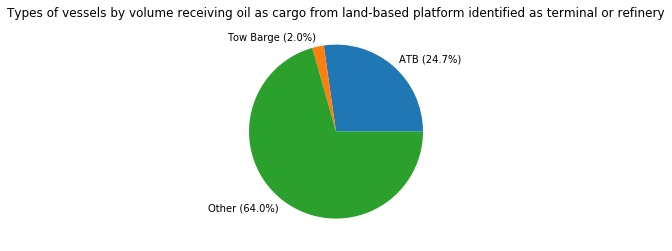

In [10]:
volume_export_byvessel = [oil_traffic['cargo']['atb_volume_export'], oil_traffic['cargo']['barge_volume_export'], oil_traffic['cargo']['other_export']]
#colors = ['b', 'g', 'r', 'c', 'm', 'y']
labels = [f'ATB ({atb_percent:3.1f}%)', f'Tow Barge ({barge_percent:3.1f}%)',f'Other ({other_percent:3.1f}%)']
plt.gca().axis("equal")
plt.pie(volume_export_byvessel, labels= labels)
plt.title('Types of vessels by volume receiving oil as cargo from land-based platform identified as terminal or refinery')

### Add up volume transferred by fuel type 

In [11]:
# Add up the total volume of marine transport by product (this includes all transfers)
gas_export_data    = cargo_data[cargo_data['Product']=='GASOLINE']
gas_export_total   = gas_export_data['TransferQtyInGallon'].sum()
gas_export_percent = 100*gas_export_total/cargo_data.TransferQtyInGallon.sum()

diesel_export_data    = cargo_data[cargo_data['Product']=='DIESEL/MARINE GAS OIL']
diesel_export_total   = diesel_export_data['TransferQtyInGallon'].sum()
diesel_export_percent = 100*diesel_export_total/cargo_data.TransferQtyInGallon.sum()

bunker_export_data  = cargo_data[cargo_data['Product']=='BUNKER OIL/HFO']
bunker_export_total = bunker_export_data['TransferQtyInGallon'].sum()
bunker_export_percent = 100*bunker_export_total/cargo_data.TransferQtyInGallon.sum()

jet_export_data   = cargo_data[cargo_data['Product']=='JET FUEL/KEROSENE']
jet_export_total  = jet_export_data['TransferQtyInGallon'].sum()
jet_export_percent = 100*jet_export_total/cargo_data.TransferQtyInGallon.sum()

ulsd_export_data  = cargo_data[cargo_data['Product']=='DIESEL LOW SULPHUR (ULSD)']
ulsd_export_total = ulsd_export_data['TransferQtyInGallon'].sum()
ulsd_export_percent = 100*ulsd_export_total/cargo_data.TransferQtyInGallon.sum()


crude_export_data  = cargo_data[cargo_data['Product'].str.contains('CRUDE')]
crude_export_total = crude_export_data['TransferQtyInGallon'].sum()
crude_export_percent = 100*crude_export_total/cargo_data.TransferQtyInGallon.sum()

Other_fuel_total = cargo_data['TransferQtyInGallon'].sum() - crude_export_total - ulsd_export_total - jet_export_total - bunker_export_total - diesel_export_total - gas_export_total 
other_fuel_percent = 100*Other_fuel_total/cargo_data.TransferQtyInGallon.sum()

total_percent = other_fuel_percent+crude_export_percent+ulsd_export_percent+jet_export_percent+bunker_export_percent+diesel_export_percent+gas_export_percent
total_percent

100.0

### Plot up results

Text(0.5,1,'Marine Oil Export from WA Refineries and Terminals')

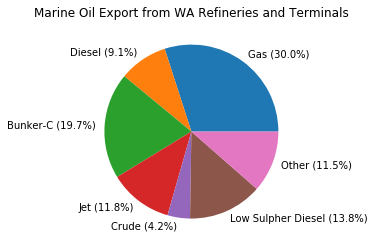

In [12]:
oil_export_values = [gas_export_total, diesel_export_total , bunker_export_total, jet_export_total, crude_export_total, ulsd_export_total, Other_fuel_total]
#colors = ['b', 'g', 'r', 'c', 'm', 'y']
labels = [f'Gas ({gas_export_percent:3.1f}%)', f'Diesel ({diesel_export_percent:3.1f}%)', f'Bunker-C ({bunker_export_percent:3.1f}%)', f'Jet ({jet_export_percent:3.1f}%)', f'Crude ({crude_export_percent:3.1f}%)', f'Low Sulpher Diesel ({ulsd_export_percent:3.1f}%)', f'Other ({other_fuel_percent:3.1f}%)']
plt.gca().axis("equal")
plt.pie(oil_export_values, labels= labels)
plt.title('Marine Oil Export from WA Refineries and Terminals')

In [14]:
cargo_data

,StartDateTime,Deliverer,Receiver,City,Product,TransferQtyInGallon,TransferType
0,2018-01-02 07:00:00,TLP Management Services LLC (TMS),GLOBAL PILOT,SEATTLE,DIESEL/MARINE GAS OIL,546000,Cargo
1,2018-01-02 07:00:00,Phillips 66 Ferndale Refinery,NATHAN SCHMIDT,FERNDALE,BUNKER OIL/HFO,1176000,Cargo
2,2018-01-02 01:00:00,Shell Puget Sound Refinery,ATB BARGE KIRBY 185-01,ANACORTES,BUNKER OIL/HFO,3150000,Cargo
3,2018-01-02 01:00:00,Shell Puget Sound Refinery,ATB BARGE KIRBY 185-01,ANACORTES,DIESEL/MARINE GAS OIL,3360000,Cargo
4,2018-01-03 02:00:00,Shell Puget Sound Refinery,CARTAGENA,ANACORTES,GASOLINE,7560000,Cargo
5,2018-01-01 00:01:00,Phillips 66 Ferndale Refinery,PROFESSOR KAREN ANN BROWN,FERNDALE,DIESEL/MARINE GAS OIL,399000,Cargo
6,2018-01-01 21:00:00,Phillips 66 Ferndale Refinery,ATB BARGE 550-2,FERNDALE,GASOLINE,3906000,Cargo
7,2018-01-02 12:00:00,Phillips 66 Ferndale Refinery,ATB BARGE FIGHT FANCONI ANEMIA,FERNDALE,GASOLINE,1890000,Cargo
8,2018-01-02 12:00:00,Phillips 66 Ferndale Refinery,ATB BARGE FIGHT FANCONI ANEMIA,FERNDALE,DIESEL/MARINE GAS OIL,1470000,Cargo
9,2018-01-02 08:00:00,Pacific Ethanol,NEW ENDEAVOR,"BOARDMAN, OR",ETHANOL,425040,Cargo
